## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib


## Load bangalore home prices into a dataframe
### Datasets are downloaded from here:
-  https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

In [2]:
df1 = pd.read_csv('bengaluru_house_prices.csv')

In [3]:
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df1.shape

(13320, 9)

In [5]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

#### Drop features that are not required to build our model

In [6]:
df2 = df1.drop(['area_type','society','balcony','availability'], axis = 'columns')
df2.shape

(13320, 5)

### Data cleaning: handling null values

In [7]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [8]:
df3 = df2.dropna()

In [9]:
df3.shape

(13246, 5)

In [10]:
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

## Feature Engineering

##### Add new feature for bhk

In [11]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

/tmp/ipykernel_8181/2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [12]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [13]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


#### Add new feature called price per square feet

In [14]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [15]:
df5.to_csv('bhp.csv', index = False)

- examine locations which is categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [16]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

In [17]:
location_stats.values.sum()

13200

In [18]:
len(location_stats[location_stats > 10])

240

In [19]:
len(location_stats)

1287

## Dimensionality Reduction

#### Any location having less than 10 data points will be tagges as "Other" location. This way number of categories can be reduced by huge amount. It will help kus with having fewer dummy columns.

In [20]:
location_stats_less_than_10 = location_stats[location_stats<=10]

In [21]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

## Outlier Removal Using Logic

**Normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. Example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [22]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [23]:
df5.shape

(13200, 7)

In [24]:
df5.price_per_sqft.describe()

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

#### Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [25]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df6 = remove_pps_outliers(df5)
df6.shape

(11434, 7)

#### Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

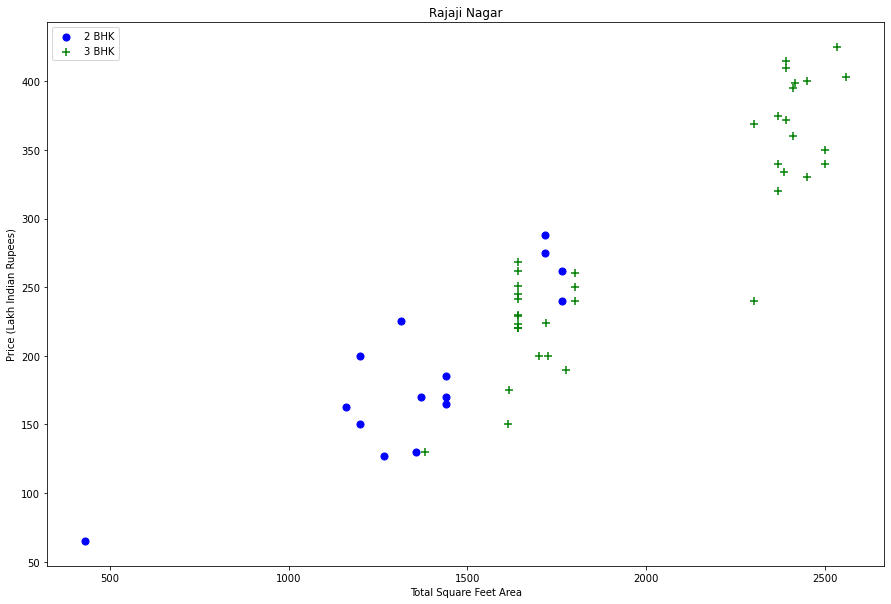

In [26]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df6,"Rajaji Nagar")

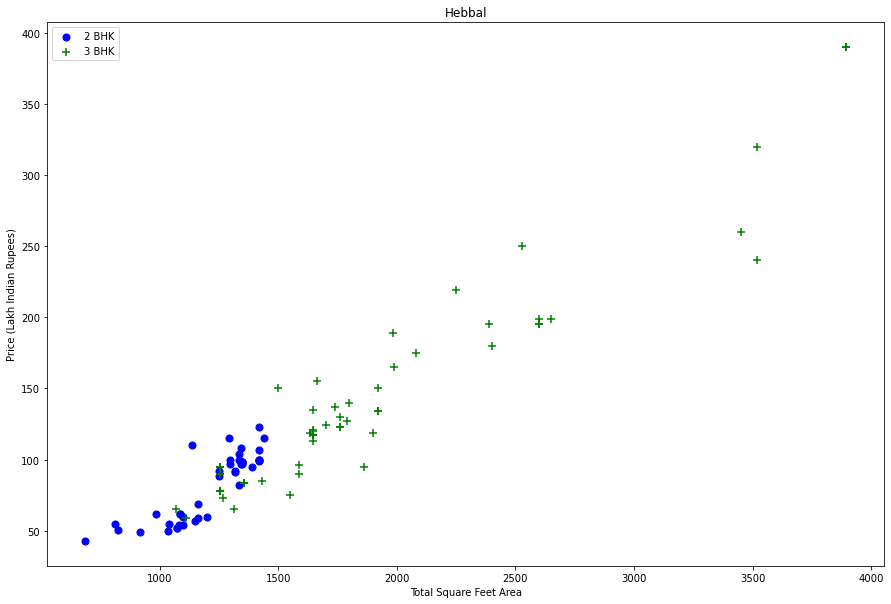

In [27]:
plot_scatter_chart(df6,"Hebbal")

Text(0, 0.5, 'Count')

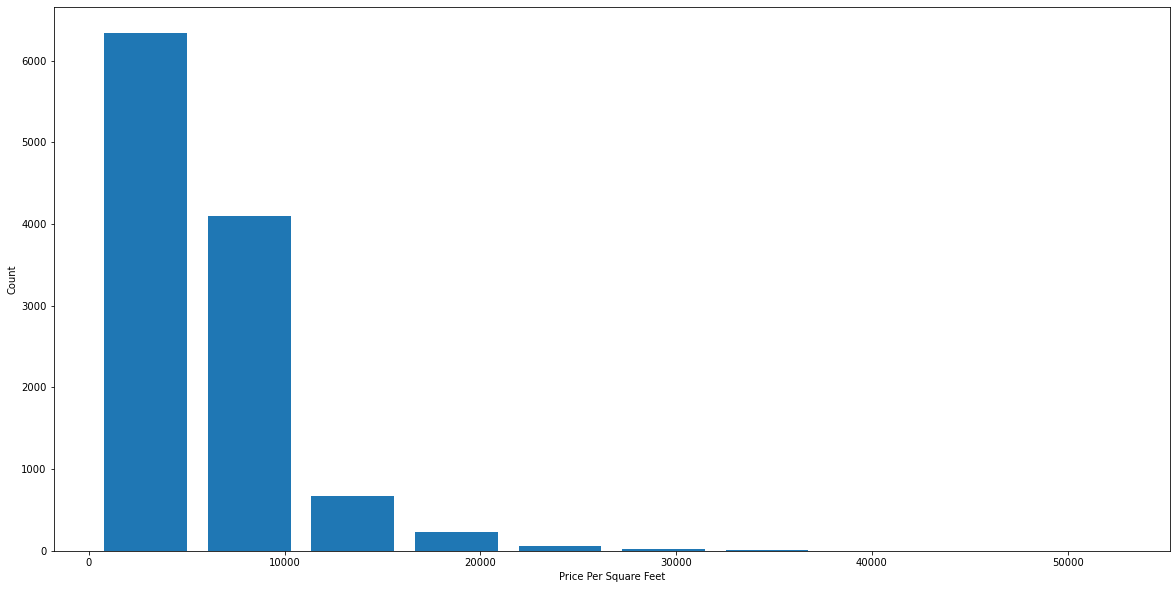

In [28]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df6.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

## Outlier removal using bathrooms feature

In [29]:
df6.bath.unique()

array([ 4.,  3.,  6.,  2.,  5.,  8.,  1.,  7.,  9., 10., 12., 14., 27.,
       11., 16., 15., 13., 18.])

Text(0, 0.5, 'Count')

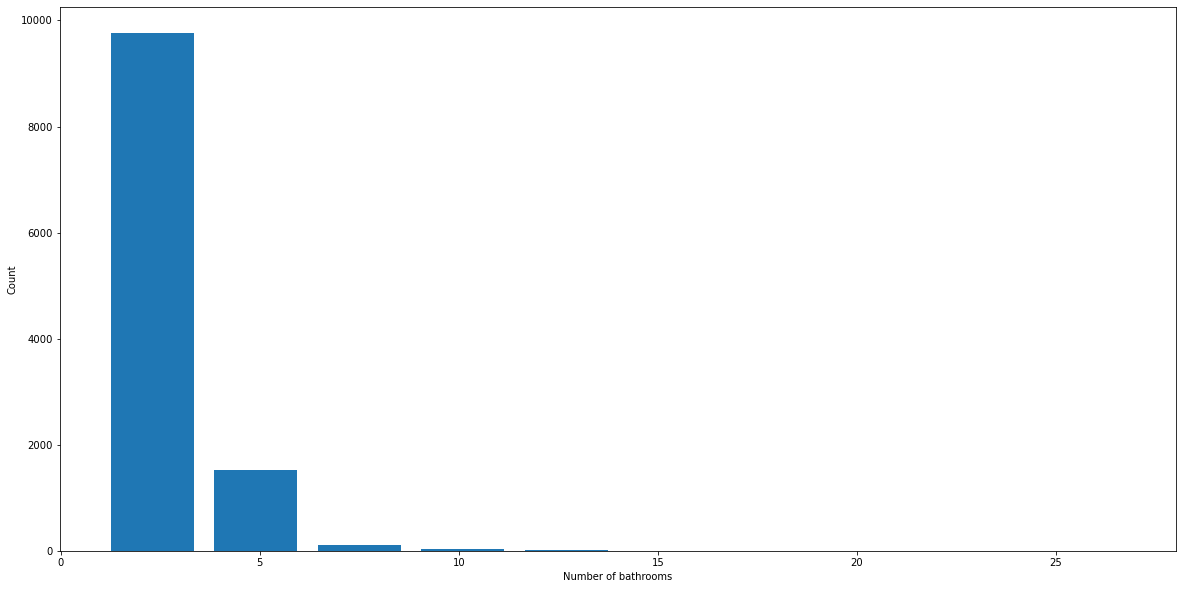

In [30]:
plt.hist(df6.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [31]:
df6[df6.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5645,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8808,other,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
8942,other,27 BHK,8000.0,27.0,230.0,27,2875.000000
8952,other,11 Bedroom,1200.0,11.0,170.0,11,14166.666667
9003,other,8 Bedroom,990.0,12.0,120.0,8,12121.212121
9235,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
9291,other,19 BHK,2000.0,16.0,490.0,19,24500.000000
9344,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9629,other,14 BHK,1250.0,15.0,125.0,14,10000.000000
10280,other,11 BHK,6000.0,12.0,150.0,11,2500.000000


#### It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [32]:
df6[df6.bath>df6.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1635,Chamrajpet,6 Bedroom,1500.0,9.0,230.0,6,15333.333333
1771,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5604,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
7229,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8808,other,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
9003,other,8 Bedroom,990.0,12.0,120.0,8,12121.212121
9146,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689
10308,other,8 Bedroom,1850.0,12.0,300.0,8,16216.216216
10693,other,3 Bedroom,2400.0,6.0,775.0,3,32291.666667
10700,other,6 Bedroom,1200.0,9.0,122.0,6,10166.666667


In [33]:
df7 = df6[df6.bath<df6.bhk+2]
df7.shape

(11307, 7)

In [34]:
df8 = df7.drop(['size','price_per_sqft'],axis='columns')
df8.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1200.0,6.0,125.0,6


## Use One Hot Encoding For Location

In [35]:
dummies = pd.get_dummies(df8.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df9 = pd.concat([df8,dummies.drop('other',axis='columns')],axis='columns')
df9.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1200.0,6.0,125.0,6,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,930.0,4.0,85.0,7,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df10 = df9.drop('location',axis='columns')

In [38]:
df10

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.00,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.00,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,6.0,125.00,6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1875.0,2.0,235.00,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,930.0,4.0,85.00,7,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11429,812.0,1.0,26.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11430,1440.0,2.0,63.93,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11431,1075.0,2.0,48.00,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11432,1200.0,5.0,325.00,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Build a Model Now

In [39]:
X = df10.drop(['price'],axis='columns')
y = df10.price

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [41]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.5194705404524206

## Use K Fold cross validation to measure accuracy of LinearRegression model

In [42]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.46159468, 0.57787149, 0.61932374, 0.22170991, 0.50560714])

#### We can see that in 5 iterations we get a score above 75% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score.

## Find best Model using GridSearchCV

In [43]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.477221,{'normalize': False}
1,lasso,0.416493,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.277726,"{'criterion': 'mse', 'splitter': 'random'}"


In [44]:
pred = lr_clf.predict(X_test)

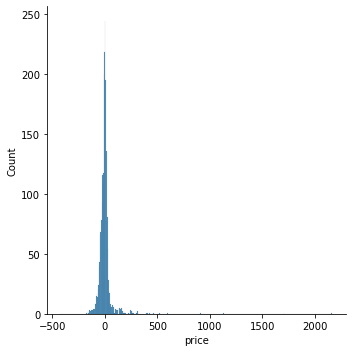

In [45]:
import seaborn as sns
sns.displot(y_test-pred)

** Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

# Using Auto SK Learn(Auto ML)

### auto-sklearn frees a machine learning user from algorithm selection and hyperparameter tuning. It leverages recent advantages in Bayesian optimization, meta-learning and ensemble construction.
- !apt-get install swig -y
- !pip install Cython numpy
- !pip install auto-sklearn

In [46]:
import autosklearn

In [47]:
import autosklearn.regression as reg

### We will use the same data we used for previous ML models

In [48]:
X_train.shape

(9045, 243)

In [49]:
automl = reg.AutoSklearnRegressor(time_left_for_this_task=120,per_run_time_limit=30)

In [50]:
automl.fit(X_train,y_train)

AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     per_run_time_limit=30, time_left_for_this_task=120)

In [51]:
print(automl.leaderboard())

          rank  ensemble_weight               type      cost   duration
model_id                                                               
8            1             0.88  gradient_boosting  0.381247   4.955073
2            2             0.12      random_forest  0.479147  23.076322


In [52]:
print(automl.show_models())

{2: {'model_id': 2, 'rank': 1, 'cost': 0.479147134987288, 'ensemble_weight': 0.12, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7fa4e0876130>, 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7fa4e08aa2b0>, 'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7fa4e08aa790>, 'sklearn_regressor': RandomForestRegressor(max_features=1.0, n_estimators=512, n_jobs=1,
                      random_state=1, warm_start=True)}, 8: {'model_id': 8, 'rank': 2, 'cost': 0.38124748970086575, 'ensemble_weight': 0.88, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7fa4e08763d0>, 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7fa4e0707d90>, 'regressor': <autosklearn.pipeline.components.regression.RegressorChoice obje

In [53]:
ypred2= automl.predict(X_test)

In [54]:
ypred2

array([548.40789795, 103.21400356,  98.6730814 , ..., 133.94945717,
        49.09346962,  55.39912319])

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


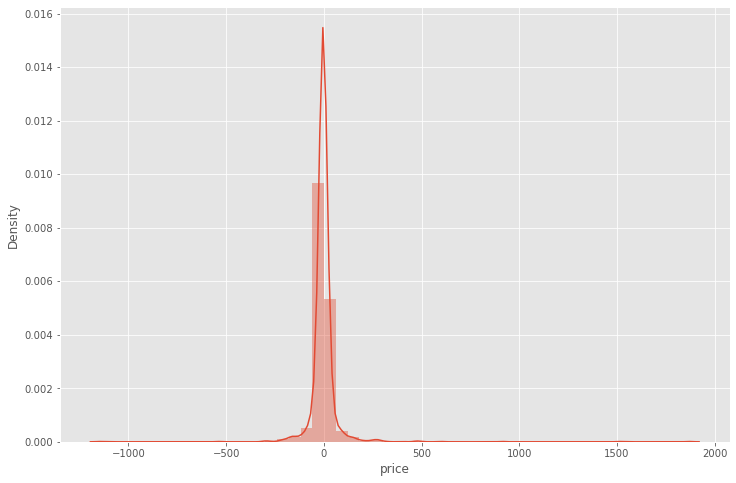

In [55]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
sns.distplot(y_test-ypred2)
plt.show()

In [56]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, ypred2))
print('MSE:', metrics.mean_squared_error(y_test, ypred2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred2)))

MAE: 27.437425208490154
MSE: 6199.289163882616
RMSE: 78.73556479687319


In [57]:
from sklearn.metrics import r2_score

In [58]:
print('R2:', metrics.r2_score(y_test, ypred2))

R2: 0.5802697930794578
